#**1. Black Scholes Model**






In [1]:
import numpy as np 
from math import sqrt, exp, log, pi
from scipy.stats import norm 

In [2]:
def BS_call_price(S_0, K, sigma, r, t, delta):
  d_1 = (log(S_0/K)+(r-delta+sigma**2/2)*t)/(sigma*sqrt(t))
  d_2 = d_1-sigma*sqrt(t) 
  return S_0*exp(-delta*t)*norm.cdf(d_1)-K*exp(-r*t)*norm.cdf(d_2)

def BS_put_price(S_0, K, sigma, r, t, delta):
  d_1 = (log(S_0/K)+(r-delta+sigma**2/2)*t)/(sigma*sqrt(t))
  d_2 = d_1-sigma*sqrt(t)
  return K*exp(-r*t)*norm.cdf(-d_2)-S_0*exp(-delta*t)*norm.cdf(-d_1)

In [3]:
S_0 = 100 
K = 120
r = 0.013            # 10 year treasury rate = 1.30% (Last Updated Aug 31 2021, 18:00 EDT)
t = 1         
delta = 0
sigma = 0.5


# Test our funcitons
print("The Black-Scholes European call option price is", BS_call_price(S_0, K, sigma, r, t, delta), 
      "\nThe Black-Scholes European put option price is", BS_put_price(S_0, K, sigma, r, t, delta))


C_0 = BS_call_price(S_0, K, sigma, r, t, delta)
P_0 = BS_put_price(S_0, K, sigma, r, t, delta)

if abs((C_0-P_0)-(S_0*exp(-delta*t)-K*exp(-r*t))) <= 0.001:
  print("\nPut-call parity is satisfied.")
else:
  print("\nPut-call parity is NOT satisfied.")

The Black-Scholes European call option price is 13.533186104198634 
The Black-Scholes European put option price is 31.983282306633136

Put-call parity is satisfied.


# **2. Newton-Raphson method**

In [4]:
def Newton_IV(option_price, S_0, K, r, t, delta, option_type="call"):
  tol = 1e-3                            # set tolerance to be 0.1%
  epsilon = 1                           # epsilon is the actual percentage change of implied volatility estimated from one iteration to the other 

  count = 0
  max_iter = 1000                       # stopping criteria

  iv = 0.5                             # initial guess of the implied volatility

  while epsilon > tol:
    count += 1
    if count >= max_iter:
      print("Break on count")
      break;
  
    orig_iv = iv                      # hold a copy of the initial guess

    d_1 = (log(S_0/K)+(r-delta+iv**2/2)*t)/(iv*sqrt(t))
    d_2 = d_1-iv*sqrt(t)

    if option_type == "call":
      diff = BS_call_price(S_0, K, iv, r, t, delta) - option_price
    
    elif option_type == "put":
      diff = BS_put_price(S_0, K, iv, r, t, delta) - option_price
    
    else:
      raise ValueError("Option_type must be 'put' or 'call'")

    vega = S_0*norm.pdf(d_1)*sqrt(t)    # derivative of the option price with respect to volatility 

    iv = -diff/vega + iv

    epsilon = abs((iv-orig_iv)/orig_iv)

    return iv


option_price = 13.5
print("The implied volatility is", Newton_IV(option_price, S_0, K, r, t, delta, "call"))




The implied volatility is 0.4991648731186123


# **3. Brent’s method**

In [5]:
from scipy.optimize import minimize_scalar 


def Brent_IV(option_price, S_0, K, r, t, delta, option_type="call"):
    
    def call_obj(sigma):
        return abs(BS_call_price(S_0, K, sigma, r, t, delta) - option_price)
    
    def put_obj(sigma):
        return abs(BS_put_price(S_0, K, sigma, r, t, delta) - option_price)
    
    if option_type == "call":
        res = minimize_scalar(call_obj, bounds=(0.01,6), method='bounded')
        return res.x
    elif option_type == 'put':
        res = minimize_scalar(put_obj, bounds=(0.01,6), method='bounded')
        return res.x
    else:
        raise ValueError("option_type must be 'put' or 'call'")

option_price = 32
print("The implied volatility is", Brent_IV(option_price, S_0, K, r, t, delta, "put"))

The implied volatility is 0.5004191938976776


# **4. Volatility Smile**

# **4.1 Get the stock info (S_0 and delta) and expiration (T)**

In [6]:
!pip install yfinance
import yfinance as yf 

In [46]:
spx = yf.Ticker('SPX')

# get the stock prices
from pandas_datareader import data as pdr
yf.pdr_override() 
history = pdr.get_data_yahoo("SPX", start="2021-1-1", end="2021-12-31")
history = history.reset_index()


# convert the columns to float type
for i in ['Open', 'High', 'Low', 'Close']:
  history[i]  =  history[i].astype('float64')

display(history)


# get the dividend rate
dividends =spx.actions     # or spx.dividends
display(dividends.tail())

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,375.309998,375.450012,364.820007,368.790009,366.387390,110210800
1,2021-01-05,368.100006,372.500000,368.049988,371.329987,368.910828,66426200
2,2021-01-06,369.709991,376.980011,369.119995,373.549988,371.116394,107997700
3,2021-01-07,376.100006,379.899994,375.910004,379.100006,376.630249,68766800
4,2021-01-08,380.589996,381.489990,377.100006,381.260010,378.776184,71677200
...,...,...,...,...,...,...,...
169,2021-09-03,451.980011,453.630005,451.549988,453.079987,453.079987,47170500
170,2021-09-07,452.709991,452.809998,450.739990,451.459991,451.459991,51671500
171,2021-09-08,450.890015,451.670013,448.859985,450.910004,450.910004,56181900
172,2021-09-09,450.700012,452.570007,448.720001,448.980011,448.980011,57970400


In [8]:
import plotly.graph_objects as go


candlestick = go.Figure(data=[go.Candlestick(x=history['Date'], open=history['Open'], high=history['High'], low=history['Low'], close=history['Close'])])
candlestick.show()


import plotly.express as px

line_chart = px.line(history, x="Date", y="Open", title='SPY Stock Prices')
line_chart.show()

# **Get the option info (option price and strike price K)**

In [13]:
!pip install yahoo-fin

     |████████████████████████████████| 81 kB 10.1 MB/s 
     |████████████████████████████████| 83 kB 2.9 MB/s 
     |████████████████████████████████| 103 kB 57.9 MB/s 
     |████████████████████████████████| 127 kB 63.6 MB/s 
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-py3-none-any.whl size=13502 sha256=4ab8d0f54ecf5c17711c7723f9fe81f9504b041e8ccb3680b3f6f7396cd4f681
  Stored in directory: /root/.cache/pip/wheels/ed/f7/62/50ab6c9a0b5567267ab76a9daa9d06315704209b2c5d032031
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24591 sha256=3296ee156ffda6f11295f46208b805e8e6aae54142141cb408ceefd488c22ab6
  Stored in directory: /root/.cache/pip/wheels/9c/aa/cc/f2228050ccb40f22144b073f15a2c84f11204f29fc0dce028e
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6065 sha256=8d710586963795b9ebf7588844bec64d5acd0ff85faf9085a4fa61ccbd83dcd1
  Stored in directory: /root/.cache/pip/wheels/73/ad/a4/0dff4a6ef231fc0dfa12ffbac2a36c

In [43]:
from yahoo_fin import options

# get the expiration dates
print("The expirations dates are", spx.options, "\n\n")

# get call options only (can take off the specific expiration date ==> gets the data for nearest upcoming expiration date)
calls = options.get_calls("SPX", '2021-12-31')
calls.rename(columns = {'Last Price':'LastPrice'}, inplace = True)
calls.rename(columns = {'Implied Volatility':'IV'}, inplace = True)
display(calls)


# get put options only
puts = options.get_puts("SPX", '2021-12-31')
puts.rename(columns = {'Last Price':'LastPrice'}, inplace = True)
puts.rename(columns = {'Implied Volatility':'IV'}, inplace = True)
display(puts)


"""
# gets the data for nearest upcoming expiration date
options.get_options_chain("nflx")

# specific expiration date
options.get_options_chain("nflx", "04/26/2019")
"""



The expirations dates are ('2021-09-10', '2021-09-13', '2021-09-15', '2021-09-17', '2021-09-20', '2021-09-22', '2021-09-24', '2021-09-27', '2021-09-29', '2021-09-30', '2021-10-01', '2021-10-04', '2021-10-06', '2021-10-08', '2021-10-11', '2021-10-15', '2021-10-22', '2021-11-19', '2021-12-17', '2021-12-31', '2022-01-21', '2022-02-18', '2022-03-18', '2022-03-31', '2022-06-17', '2022-06-30', '2022-09-16', '2022-12-16', '2023-01-20', '2023-03-17', '2023-06-16', '2023-12-15') 




,Contract Name,Last Trade Date,Strike,LastPrice,Bid,Ask,Change,% Change,Volume,Open Interest,IV
0,SPY211231C00200000,2021-08-23 12:12PM EDT,200.0,247.90,245.11,246.49,0.00,-,10,12,62.11%
1,SPY211231C00205000,2021-08-25 5:21PM EDT,205.0,201.87,239.98,241.62,0.00,-,-,10,60.30%
2,SPY211231C00210000,2021-08-25 5:21PM EDT,210.0,212.00,235.17,236.62,0.00,-,1,0,60.45%
3,SPY211231C00220000,2021-08-25 5:22PM EDT,220.0,195.78,225.19,226.48,0.00,-,2,37,55.91%
4,SPY211231C00225000,2021-08-25 5:22PM EDT,225.0,181.97,220.20,221.62,0.00,-,-,15,55.59%
...,...,...,...,...,...,...,...,...,...,...,...
190,SPY211231C00535000,2021-09-10 10:30AM EDT,535.0,0.04,0.04,0.05,-0.02,-33.33%,1,505,12.65%
191,SPY211231C00540000,2021-09-10 3:29PM EDT,540.0,0.04,0.03,0.04,-0.01,-20.00%,15,444,12.89%
192,SPY211231C00550000,2021-09-08 10:52AM EDT,550.0,0.04,0.03,0.04,0.00,-,3,566,13.97%
193,SPY211231C00560000,2021-09-10 12:05PM EDT,560.0,0.02,0.01,0.00,-0.01,-33.33%,4,727,6.25%


,Contract Name,Last Trade Date,Strike,LastPrice,Bid,Ask,Change,% Change,Volume,Open Interest,IV
0,SPY211231P00200000,2021-09-10 4:12PM EDT,200.0,0.26,0.26,0.28,0.03,+13.04%,27,5474,60.01%
1,SPY211231P00205000,2021-09-10 9:30AM EDT,205.0,0.24,0.28,0.30,0.00,-,1,639,58.84%
2,SPY211231P00210000,2021-09-10 10:47AM EDT,210.0,0.27,0.31,0.33,0.02,+8.00%,1,1311,57.84%
3,SPY211231P00215000,2021-09-07 9:30AM EDT,215.0,0.29,0.34,0.36,0.00,-,1,1359,56.81%
4,SPY211231P00220000,2021-09-09 10:46AM EDT,220.0,0.28,0.37,0.39,0.00,-,1,233,55.76%
...,...,...,...,...,...,...,...,...,...,...,...
177,SPY211231P00515000,2021-09-10 3:17PM EDT,515.0,70.30,71.17,72.52,0.70,+1.01%,1,4,21.20%
178,SPY211231P00530000,2021-08-25 5:26PM EDT,530.0,117.96,86.08,87.45,0.00,-,-,3,23.93%
179,SPY211231P00535000,2021-08-19 9:52AM EDT,535.0,99.11,91.07,92.43,0.00,-,-,2,24.80%
180,SPY211231P00540000,2021-08-19 9:52AM EDT,540.0,104.06,96.05,97.42,0.00,-,1,6,25.68%


'\n# gets the data for nearest upcoming expiration date\noptions.get_options_chain("nflx")\n\n# specific expiration date\noptions.get_options_chain("nflx", "04/26/2019")\n'

#**4.2 Construct the volatility smile**

In [47]:
display(history.tail())

,Date,Open,High,Low,Close,Adj Close,Volume
169,2021-09-03,451.980011,453.630005,451.549988,453.079987,453.079987,47170500
170,2021-09-07,452.709991,452.809998,450.739990,451.459991,451.459991,51671500
171,2021-09-08,450.890015,451.670013,448.859985,450.910004,450.910004,56181900
172,2021-09-09,450.700012,452.570007,448.720001,448.980011,448.980011,57970400
173,2021-09-10,451.040009,451.489990,445.309998,445.440002,445.440002,78592111


In [12]:
#!pip install timedelta

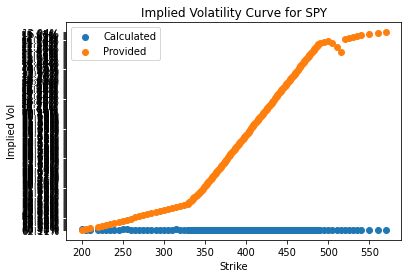

In [48]:
import datetime as dt
import matplotlib.pyplot as plt

#yf.pdr_override()
#spy_option = web.YahooOptions('SPY')
#data = spy_option.get_call_data()

calls2 = calls

today = dt.date.today()
expiration = dt.date(2021, 12, 31)
time_to_expiration = expiration - today
time_to_expiration = int(time_to_expiration.days)/365

calls2['time_to_expiration'] = time_to_expiration

open = float(history.iloc[173]["Open"])
close = float(history.iloc[173]["Close"])
calls2['spot_price'] = (open+close)/2


ivs = [] 

for row in calls2.itertuples():
    iv = Brent_IV(row.LastPrice, row.spot_price, row.Strike, 0.013, row.time_to_expiration, 0.0123, "call")
    ivs.append(iv)



plt.scatter(calls2.Strike, ivs, label='Calculated')
plt.scatter(calls.Strike, calls.IV, label='Provided')
plt.xlabel('Strike')
plt.ylabel('Implied Vol')
plt.title('Implied Volatility Curve for SPX')
plt.legend() 




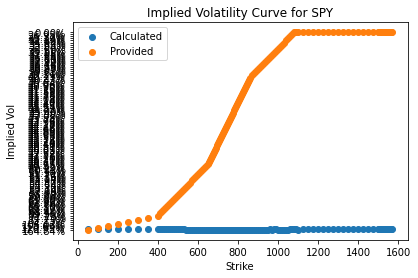

In [32]:
import datetime as dt
import matplotlib.pyplot as plt

#yf.pdr_override()
#spy_option = web.YahooOptions('SPY')
#data = spy_option.get_call_data()

puts2 = puts

today = dt.date.today()
expiration = dt.date(2023, 12, 15)
time_to_expiration = expiration - today
time_to_expiration = int(time_to_expiration.days)/365

puts2['time_to_expiration'] = time_to_expiration

open = float(history.iloc[173]["Open"])
close = float(history.iloc[173]["Close"])
puts2['spot_price'] = (open+close)/2


ivs = [] 

for row in puts2.itertuples():
    iv = Brent_IV(row.LastPrice, row.spot_price, row.Strike, 0.013, row.time_to_expiration, 0.0123, "put")
    ivs.append(iv)



plt.scatter(puts2.Strike, ivs, label='Calculated')
plt.scatter(puts.Strike, puts.IV, label='Provided')
plt.xlabel('Strike')
plt.ylabel('Implied Vol')
plt.title('Implied Volatility Curve for SPY')
plt.legend() 
